<a href="https://colab.research.google.com/github/leekate/2020-ctrc-OralCancer-Classification-project/blob/master/Oral_Detect_my_ResNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

!pip uninstall keras
!pip install Keras==2.2.4

!pip uninstall tensorflow
!pip install tensorflow==1.13.1

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# 본격적인 설계 시작
## ResNet

In [13]:
#PRE-trained

from tensorflow.keras.applications import ResNet50
import keras
from tensorflow.keras.layers import Dropout, MaxPooling2D,Dense,Flatten,GlobalAveragePooling2D
from tensorflow.keras import models,layers
from keras.models import Model

base_model = keras.applications.resnet.ResNet50(include_top=False, weights='imagenet', 
                                                input_tensor=None, input_shape=(224,224,3), pooling=None, classes=4)

x=base_model.layers[-2].output
predictions=Dense(4,activation='relu')(x)
predictions = GlobalAveragePooling2D()(predictions)
model = Model(base_model.input, predictions)

# model=models.Sequential()
# model.add(base_model)
# model.add(layers.Flatten())
# #model.add(layers.Dropout(0.2))
# model.add(layers.Dense(256,activation='relu'))
# model.add(layers.Dense(4,activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
              

In [14]:
#conv_base.trainable=False
#weight가 업데이트되지 않도록


#conv_base.trainable=True

In [15]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
____________________________________________________________________________________________

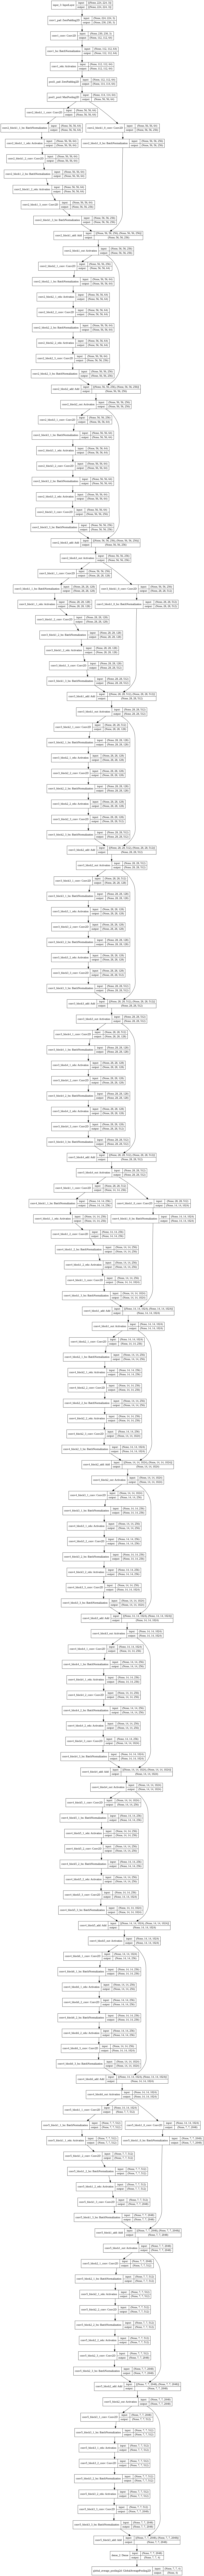

In [16]:
from keras.utils import plot_model
from keras.models import load_model
#model = load_model('/content/drive/Shareddrives/CTRC-OralDetect-Project/jiwoo_model/ResNet50/210128_my_Resnet_model.h5')
plot_model(model,show_shapes=True,to_file='/content/drive/Shareddrives/CTRC-OralDetect-Project/jiwoo_model/RealResnet/my_Resnet_model.png') 

## Training

In [17]:
from keras.models import load_model
import os
# model checkpoint
# model_sav_path = '/content/drive/Shareddrives/CTRC-OralDetect-Project/jiwoo_model/ResNet50'

# if not os.path.isdir(model_sav_path):
#     os.mkdir(model_sav_path)
    
# model_path = model_sav_path + '/210131_my_Resnet_model_01.h5'


In [18]:
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import os

save_dir="/content/drive/Shareddrives/CTRC-OralDetect-Project/jiwoo_model/RealResnet/first"
if not os.path.isdir(save_dir):
    os.mkdir(save_dir)
    
checkpointer=ModelCheckpoint(os.path.join(save_dir,'{epoch:0.3f}_valloss{val_loss:0.4f}.hdf5'),
                             verbose=1,
                             save_best_only=True)
es=EarlyStopping(monitor='val_loss',mode='min')

In [19]:
train_dir='/content/drive/Shareddrives/CTRC-OralDetect-Project/NewDataGenerate-HM/train'
validation_dir='/content/drive/Shareddrives/CTRC-OralDetect-Project/Original/validation'
test_dir='/content/drive/Shareddrives/CTRC-OralDetect-Project/Original/test'

In [20]:
#flow_from_directory는 이미지를 불러올 때 폴더명에 맞춰 자동으로 labelling을 햅줌
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator,array_to_img,img_to_array, load_img
import numpy as np

np.random.seed(3)

imageGenerator = ImageDataGenerator(rescale=1./255)
trainGen = imageGenerator.flow_from_directory(train_dir,
                                              target_size=(224,224))
                                            

validationGen = imageGenerator.flow_from_directory(validation_dir,
                                              target_size=(224,224))
                                              
testGen = imageGenerator.flow_from_directory(test_dir,
                                              target_size=(224,224))

Found 2361 images belonging to 4 classes.
Found 629 images belonging to 4 classes.
Found 629 images belonging to 4 classes.


* steps_per_epoch : 한 epoch에 사용한 스텝 수를 지정합니다. 총 2361개의 훈련 샘플이 있고 배치사이즈가 32이므로 73 스텝으로 지정합니다.
* validation_data : 검증데이터셋을 제공할 제네레이터를 지정합니다. 여기서는 앞서 생성한 validation_generator으로 지정합니다.
* validation_steps : 한 epoch 종료 시 마다 검증할 때 사용되는 검증 스텝 수를 지정합니다. 총 629개의 검증 샘플이 있고 배치사이즈가 32이므로 19 스텝으로 지정합니다.
* epochs : 전체 훈련 데이터셋에 대해 학습 반복 횟수를 지정합니다. 50번을 반복적으로 학습시켜 보겠습니다.


In [21]:
trainGen

In [22]:
type(validationGen)

tensorflow.python.keras.preprocessing.image.DirectoryIterator

In [23]:
history=model.fit_generator(trainGen,steps_per_epoch=73, epochs=30,
                  validation_data=validationGen,validation_steps=19,
                  callbacks=[checkpointer,es])

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/30


InvalidArgumentError: ignored

In [ ]:
model.save('/content/drive/Shareddrives/CTRC-OralDetect-Project/jiwoo_model/RealResnet/RealResnet.h5')

# Testing

In [ ]:
#일반 모델
model.evaluate_generator(testGen) 

In [ ]:
#특정 weight 지정
import matplotlib.pyplot as plt
from keras.models import load_model
predict=model.predict(testGen)


#predict


np.set_printoptions(threshold=np.inf)
print(np.array(predict))

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# 분류결과표 - 정답 : 행 / 예측 : 열
#confusion_matrix(y_pred, y_test)
confusion_matrix(testGen, predict)

# 오분류표
classification_report(testGen, predict)

# 분류정확도
accuracy_score(testGen, predict)

In [ ]:
predict.shape

In [ ]:
type(testGen)

## Result

In [ ]:
from tensorflow.keras.preprocessing.image import array_to_img
import numpy as np

cls_index = ['Cancer', 'Precancer','Inflammatory','Normal']

imgs = testGen.next()
arr = imgs[0][0]
img = array_to_img(arr).resize((128, 128))
plt.imshow(img)
result = model.predict_classes(arr.reshape(1, 224, 224, 3))
print('예측: {}'.format(cls_index[result[0]]))
print('정답: {}'.format(cls_index[np.argmax(imgs[1][0])]))


### 정확도 및 손실 그래프

In [ ]:
import matplotlib.pyplot as plt


acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()




# import matplotlib.pyplot as plt


# acc = history.history['acc']
# val_acc = history.history['val_acc']
# loss = history.history['loss']
# val_loss = history.history['val_loss']

# epochs = range(len(acc))

# plt.plot(epochs, acc, 'r', label='Training acc')
# plt.plot(epochs, val_acc, 'b', label='Validation acc')
# plt.title('Training and validation accuracy')
# plt.legend()

# plt.figure()

# plt.plot(epochs, loss, 'r', label='Training loss')
# plt.plot(epochs, val_loss, 'b', label='Validation loss')
# plt.title('Training and validation loss')
# plt.legend()

# plt.show()

### 모델 불러와서 예측하기

In [ ]:
# import matplotlib.pyplot as plt
# from keras.models import load_model
# model = load_model('/content/drive/Shareddrives/CTRC-OralDetect-Project/jiwoo_model/ResNet50/NewWeight07/3.000_valloss4.0873.hdf5')

# predict=model.predict(testGen)

In [ ]:
# np.set_printoptions(threshold=np.inf)
# print(np.array(predict))

# 알고리즘 CNN
* 심층 신경망(DNN, Deep Neural Network)
* 합성곱 신경망(CNN, Convoultional Neural Network)
* 순환 신경망(RNN, Recurrent Neural Network)
* 제한 볼츠만 머신(RBM, Restricted Boltzmann Machine)
* 심층 신뢰 신경망(DBN, Deep Belief Network)



CNN. 합성곱신경망 [Convolutional Neural Network]

CNN은 하나 이상의 합성곱 계층과 그 위에 올려진 일반적인 인공 신경망 계층들로 이루어져 있고, 가중치와 레이어들을 추가로 활용한다. 이러한 구조로 CNN은 2차원 구조의 입력 데이터를 충분히 활용할 수 있다. 다른 딥러닝 구조들과 비교했을 때, CNN은 영상과 음성 분야 모두에서 좋은 성능을 보인다. 또한 표준 역전달을 통해 훈련될 수 있고, 적은 수의 매개변수를 사용한다는 이점이 있다. 

 CNN은 마지막 레이어에 손실 함수를 가지며, 우리가 일반 신경망을 학습시킬 때 사용하던 각종 기법들을 동일하게 적용할 수 있다. CNN은 이미지 및 비디오 인식, 추천 시스템 및 자연 언어 처리 등에 응용된다.

# 텐서플로우의 시각화 프레임워크

In [ ]:
from keras.utils import plot_model
plot_model(model, to_file='Contrast_Resnet_model.png')

In [ ]:
%load_ext tensorboard
%tensorboard --logdir=my_log_dir

# 최대 epoch
```
early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50)
```
성능이 증가하지 않는다고, 그 순간 바로 멈추는 것은 효과적이지않을 수 있다. patience 는 성능이 증가하지 않는 epoch 을 몇 번이나 허용할 것인가를 정의
